In [21]:
import numpy as np
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import cv2
import random

import scipy.ndimage as ndi

import skimage
from skimage import transform as tf

from sklearn.metrics import average_precision_score

from scipy import ndimage
import skimage.filters as filters

from scipy.optimize import minimize_scalar
import numba

import multiprocessing as mp

import time

### Advandced Dummy Data Generation

In [2]:
def generate_dummydata(n=10, dimensions=(28, 28), distortedness=1):

    h, w = dimensions

    # Generating 10 random images of size 28x28
    gt = np.zeros((n, h, w))
    pr = np.zeros((n, h, w))

    objects = ['circle', 'rectangle', 'triangle']

    for i in range(n):
        # Generating random objects in the ground truth
        num_objects = np.random.randint(1, 4)
        for j in range(num_objects):
            object_type = np.random.choice(objects)
            if object_type == 'circle':
                center_x = np.random.randint(0, h)
                center_y = np.random.randint(0, w)
                radius = np.random.randint(3, min(h, w)//4)
                cv2.circle(gt[i], (center_x, center_y), radius, 1, 1)
            elif object_type == 'rectangle':
                start_x = np.random.randint(0, h)
                start_y = np.random.randint(0, w)
                end_x = np.random.randint(start_x, h)
                end_y = np.random.randint(start_y, w)
                cv2.rectangle(gt[i], (start_x, start_y), (end_x, end_y), 1, 1)
            else:
                points = np.array([[np.random.randint(0, h), np.random.randint(0, w)],
                                  [np.random.randint(0, h), np.random.randint(0, w)],
                                  [np.random.randint(0, h), np.random.randint(0, w)]])
                cv2.drawContours(gt[i], [points], 0, 1, 1)

        # Copying the ground truth to the predictions
        pr[i] = gt[i].copy()


        # Skewing the predictions
        for i in range(n):
            tform = tf.AffineTransform(scale=(1, np.random.uniform(1-0.01*distortedness, 1 + 0.01*distortedness)),
                                    rotation=np.random.uniform(-0.01*distortedness, 0.01*distortedness),
                                    shear=np.random.uniform(-0.01*distortedness, 0.01*distortedness))
                                    
            pr[i] = tf.warp(pr[i], tform, mode='edge')
            pr[i] = filters.gaussian(pr[i], sigma=0.2*distortedness)

    return pr, gt

In [3]:
def plot_datasets(pr, gt):

    fig, axs = plt.subplots(nrows=3, ncols=10, figsize=(15, 5))
    fig.suptitle('Comparison of Ground Truth, Predictions and Difference')

    axs[0, 0].set_title("Ground truth")
    axs[1, 0].set_title("Predictions")
    axs[2, 0].set_title("Difference")

    for i in range(10):
        axs[0, i].imshow(gt[i], cmap='gray')    
        axs[1, i].imshow(pr[i], cmap='gray')
        axs[2, i].imshow(abs(gt[i]-pr[i]), cmap='inferno')

    plt.show()

In [176]:
def evaluate_at_matching_distance(gt, pr, matching_distance, n_thresholds=10, average = 'macro'):
    
    # Create a square structuring element
    struct_elem = np.ones((1, 2 * matching_distance + 1, 2 * matching_distance + 1), dtype=bool)

    # Perform dilation on the edge map
    if matching_distance > 0:
        gt_dilate = ndimage.binary_dilation(gt, structure=struct_elem)
    else:
        gt_dilate = gt
    
    thresholds = np.linspace(0, 1, num=n_thresholds)

    # ODF calculation
    f1_scores = []
    for t in thresholds:
        pred_bin = (pr > t).astype(int)
        gt_matching = np.copy(gt)
        gt_matching[np.logical_and(pred_bin == gt_dilate, pred_bin == 1)] = 1 
        f1_scores.append(f1_score(gt_matching.ravel(), pred_bin.ravel(), average=average))
    maxarg = np.argmax(f1_scores)
    odf = f1_scores[maxarg]
    best_threshold = thresholds[maxarg]

    # OIF calculation
    best_f1_scores = []
    for i in range(pr.shape[0]):
        f1_scores = []
        for t in thresholds:
            pred = (pr[i] > t).astype(int)
            gt_matching = np.copy(gt[i])
            gt_matching[np.logical_and(pred == gt_dilate[i], pred == 1)] = 1 
            f1_scores.append(f1_score(gt_matching.ravel(), pred.ravel(), average=average))
        best_f1_scores.append(np.max(f1_scores))
    oif = np.mean(best_f1_scores)

    pred_bin = (pr > best_threshold).astype(int)
    gt_matching = np.copy(gt)
    gt_matching[np.logical_and(pred_bin == gt_dilate, pred_bin == 1)] = 1 

    # AP
    ap = average_precision_score(gt_matching.ravel(), pr.ravel(), average=average)

    return odf, oif, ap, best_threshold

In [178]:
def plot_results(datasets, matching_distances, dataset_labels=None):
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    ax = ax.ravel()
    
    if dataset_labels == None:
        dataset_labels = np.arange(len(datasets))

    for i, dataset in enumerate(datasets):
        gt, pr = dataset
        odfs = []
        oifs = []
        aps = []
        for matching_distance in matching_distances:
            odf, oif, ap, _ = evaluate_at_matching_distance(gt, pr, matching_distance)
            odfs.append(odf)
            oifs.append(oif)
            aps.append(ap)
        
        ax[0].plot(matching_distances, oifs, label=dataset_labels[i])
        ax[1].plot(matching_distances, odfs, label=dataset_labels[i])
        ax[2].plot(matching_distances, aps, label=dataset_labels[i])
    
    ax[0].set_title("OIF")
    ax[1].set_title("ODF")
    ax[2].set_title("AP")

    for i in range(3):
        ax[i].set_xlabel("Matching Distance (pixels)")
        ax[i].legend()
        ax[i].set_ylim([0,1])
    plt.show()

In [179]:
# Example usage
pr1, gt1 = generate_dummydata(n=10, dimensions=(64, 64), distortedness=2)
pr2, gt2 = generate_dummydata(n=10, dimensions=(64, 64), distortedness=5)
dataset_labels = ['better dataset', 'shittier dataset']

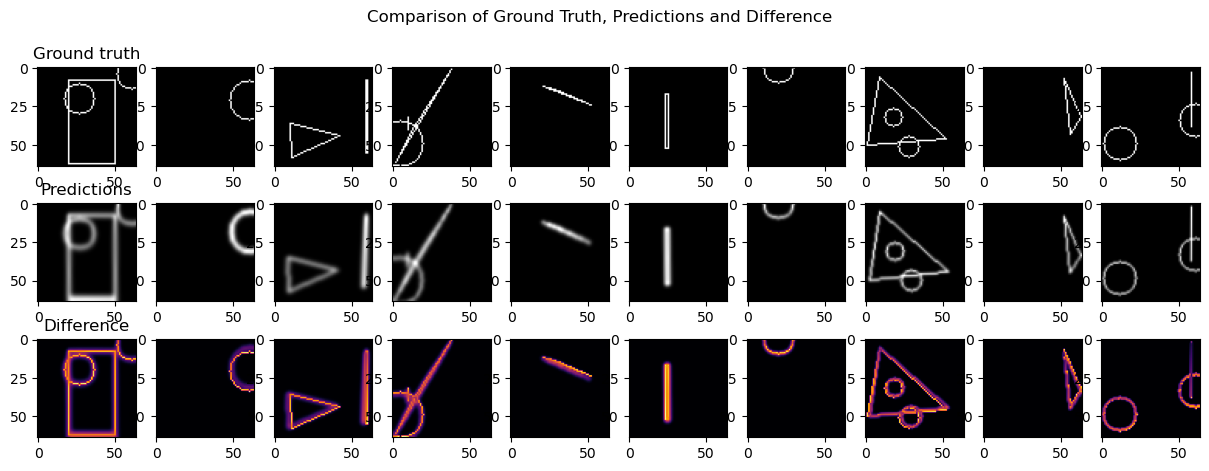

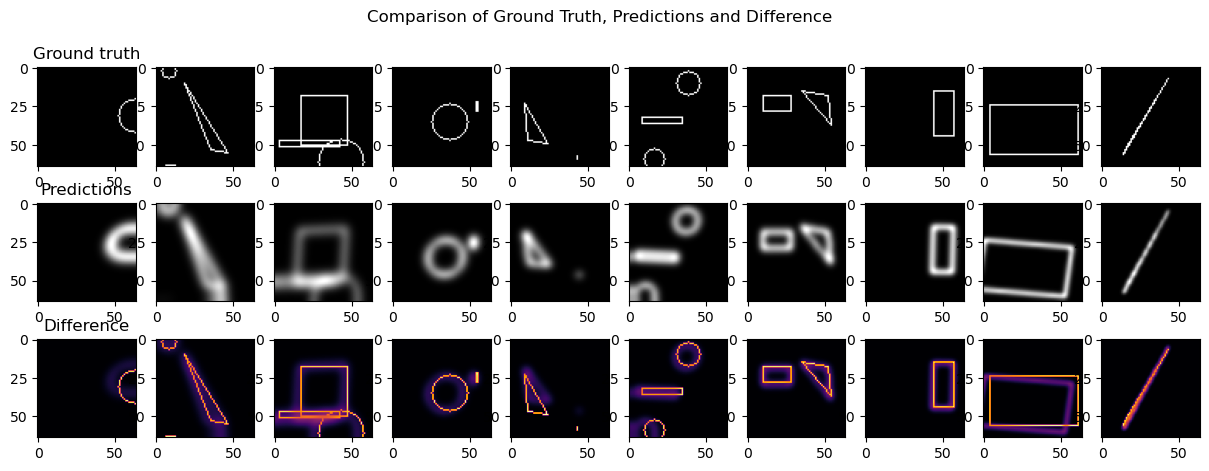

In [180]:
plot_datasets(pr1, gt1)
plot_datasets(pr2, gt2)

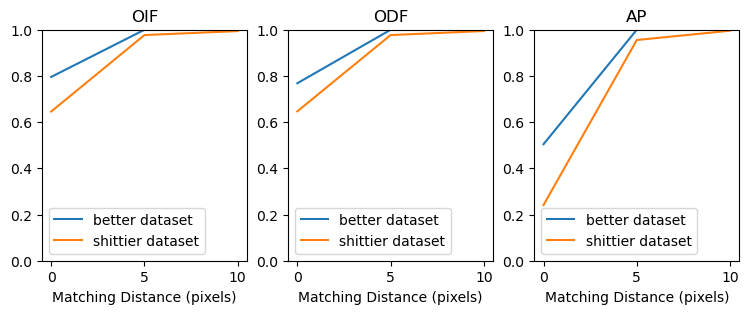

In [181]:
matching_distances = [0, 5, 10]
plot_results(datasets=[(gt1, pr1), (gt2, pr2)], matching_distances=matching_distances, dataset_labels=dataset_labels)